In [101]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
# from alice.segmentation import get_segmentation_masks
from alice.label_transformation import define_box_around_label



In [733]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [734]:
paths = [PROCESSING_INPUT_DIR / f'011245996_additional_{i}.jpeg' for i in range(1,5)]

In [912]:
# UTILS function


class AngledView():

    """
    A view of the specimen 
    """

    min_mask_size = 1500
    
    def __init__(self, path: Path):
        # FIXME: Reading image twice
        self.image = cv2.imread(str(path))
        self.predictions = predict_masks(path)
        self.masks = self.masks_from_predictions(self.predictions)

    def self.predictions(self, predictions):
        masks = self.predictions.get('instances').to("cpu").pred_masks       
        masks = self.filter_small_masks(masks)
        masks = self.remove_overlaps(masks)
        # Sort by mask y midpoint
        masks.sort(key=mask_get_y_midpoint)
        return masks
        
    def filter_small_masks(self, masks: np.array):
        return [m for m in masks if np.count_nonzero(m) > self.min_mask_size]

    def remove_overlaps(self, masks: np.array):
        # FIXME: Doesn't work in Ariana's code
        return masks

    def __len__(self):
        return len(self.masks)
    
    # @property
    # def num_masks(self):
    #     return len(self.masks)

    # @property
    # def mask_midpoints_y(self):
    #     # FIXME: Not needed??
    #     return [
    #         get_mask_y_midpoint(m)
    #         for m in view.masks
    #     ]        

# view = AngledView(paths[0])

class Specimen():
    def __init__(self, paths: List[Path]):
        self.views = [AngledView(p) for p in paths]
        # TODO: Get the mean of the mask count, and drop any views not corresponding to mean
        # TODO: Log error

    def __iter__(self):
        for view in self.views:
            yield view

    def __len__(self):
        return len(self.views)

    def __getitem__(self, i):
        return self.views[i]

    # def get_composites(self):
    #     for view in self.views:
    #         view.get()
        

# def segment_image(path: Path) -> np.array:
#     prediction = predict_masks(path)
#     return prediction.get('instances').to("cpu").pred_masks
        
# masks = [segment_image(p) for p in paths]

specimen = Specimen(paths)

In [913]:
view = specimen[1]

x = visualise_mask(view.image, view.predictions)

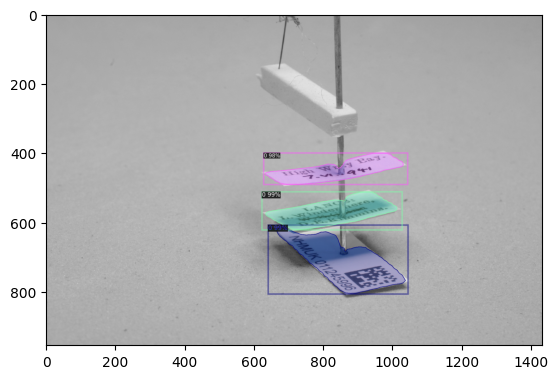

In [915]:
# cv2.fillPoly(img, [poly], (0, 0, 255))
plt.imshow(x)
plt.show()

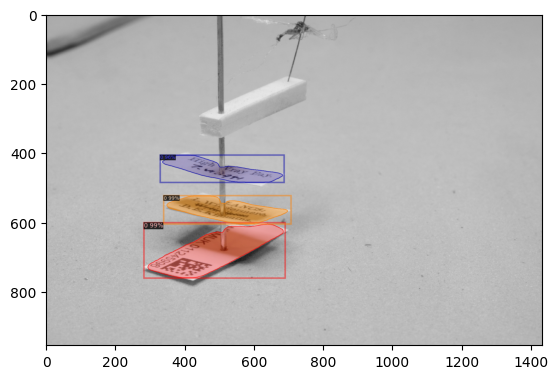

In [106]:
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.show()

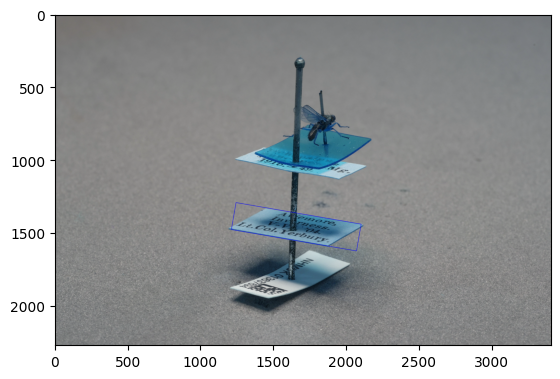

In [92]:
# rect = cv2.minAreaRect(view.masks[0].numpy().astype(np.uint8))

mask = view.masks[2].numpy()
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the largest contour (assuming it's the one you want)
largest_contour = max(contours, key=cv2.contourArea)
rect = cv2.minAreaRect(largest_contour)


box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(view.image,[box],0,(0,0,255),2)

# image = np.zeros_like(mask)
# cv2.drawContours(view.image, [box], 0, 1, 2)

# # Display the image using matplotlib
plt.imshow(view.image, cmap='gray')
plt.show()

# contours = measure.find_contours(mask, 0.8)
# # rect = cv2.minAreaRect(contours[0].copy())
# c = contours[0]
# c.shape
# # contours[0]
# # mask = view.masks[0].numpy()

# # _,contours,_ = cv2.findContours(mask.copy(), 1, 1)



In [741]:
import cv2
import numpy as np
import sympy




mask = view.masks[2].numpy()

# I can simplify with approxPolyDP?
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

approxPolyDP

# # Get the largest contour (assuming it's the one you want)
# largest_contour = max(contours, key=cv2.contourArea)    

vertices = appx_best_fit_ngon(contours)


In [175]:
vertices

[(1304, 911), (1498, 1105), (1236, 1160), (917, 874)]

In [178]:
img = deepcopy(view.image)

In [172]:
pt = max(vertices, key=lambda x: x[1])
pt

(1236, 1160)

In [208]:
# https://docs.sympy.org/latest/modules/geometry/polygons.html
from sympy import Point, Polygon

# poly = Polygon(vertices)

p1, p2, p3, p4 = map(Point, vertices)
poly = Polygon(p1, p2, p3, p4)

angle = poly.angles[p2].evalf()

In [207]:
p3

Point2D(1236, 1160)

In [209]:
# angle = np.radians(angle)

line_length = 300

end_point = (int(pt[0] + line_length * np.cos(float(angle))),
             int(pt[1] + line_length * np.sin(float(angle))))

In [210]:
img = cv2.circle(img, (1304, 911), 20, (255,255,0), 3)
img = cv2.line(img, pt, end_point, (0, 255, 0), 20)

In [212]:
from imutils import perspective

In [222]:
# vertices

# perspective.order_points(list(map(list, vertices)))
pts = np.array([[10,10],
               [10,20],
               [20,20],
               [30,10]])

pts = np.array(list(map(list, vertices)))

# https://github.com/PyImageSearch/imutils/blob/master/imutils/perspective.py
rect = perspective.order_points(pts)

(tl, tr, br, bl) = rect

In [228]:
(tl, tr, br, bl) = rect

In [242]:

corners = OrderedDict(zip(['tl', 'tr', 'br', 'bl'], rect))

In [810]:
from collections import OrderedDict
from itertools import zip_longest

class Quadrilateral:
    def __init__(self, vertices):
        ordered_points = perspective.order_points(
            np.array(list(map(list, vertices)))
        )
        # Rename vertices
        self.vertices = OrderedDict(zip(['tl', 'tr', 'br', 'bl'], ordered_points))
        # Closest point to the bottom of screen
        self.closest_point = max(self.points, key= lambda x: self.vertices[x][1])
        
    def iter_keys(self):
        # Iterable list of keys, starting and ending from  closest point
        # e.g. ['bl', 'tl', 'tr', 'br', 'bl']
        x = list(corners.keys())
        i = x.index(self.closest_point)
        yield from x[i:] + x[:i] + [self.closest_point]        

quad = Quadrilateral(vertices)

keys = list(quad.points.keys())

# for k, v in quad.points.items():
#     next = 
#     print(k)

def pairwise(iterable):
    return zip_longest(iterable, iterable[1:], fillvalue=iterable[0])

edges = {f'{k1}_{k2}': (quad.points[k1].tolist(), quad.points[k2].tolist()) for k1, k2 in pairwise(keys)}
    
# # THESE angles are wrong
# for k1, k2 in pairwise(keys):
#     print(f'{k1}_{k2}')
#     point1 = quad.points[k1]
#     point2 = quad.points[k2]


    
#     # Calculate the angle in radians using arctan2
#     # Angle from what, should be vectors?!?!?!?!
#     angle_radians = np.arctan2(point1, point2)
#     angle_degrees = np.degrees(angle_radians)
#     print(angle_degrees)

    # TODO - we do need line angles too - to calculate box
    
    # TODO - I can get angle to left - bl at start - bl_tl
    # angle to right bl at end br_bl
    

    # # Convert the angle to degrees
    # angle_degrees = np.degrees(angle_radians)

    # print(point1)

# list(pairwise(keys))    
# for i, k in enumerate(keys):
#     # prev_i = i-1 if i > 0 else len(keys)
#     next_i = keys.get(i+1)
    
#     # i+1 if i <= len(keys) else 0
#     # print(prev_i)
#     print(next_i)

# for i in quad.iter_keys():
#     print(i)

# print(edges['bl_tl'])

In [811]:
edge = edges['bl_tl']
edge

([1236.0, 1160.0], [917.0, 874.0])

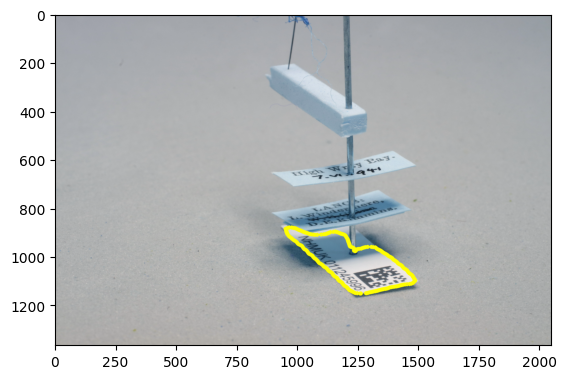

In [812]:
mask = view.masks[2].numpy()
img = deepcopy(view.image)

# np.diff(np.hstack((0, mask)))

def mask_get_edges(mask):
    """
    Get edges of a mask
    """
    h = mask.shape[0]
    # Diff will reduce width by 1, so prepend with extra column of 0s
    return np.diff(mask, prepend=np.zeros(h)[0])

def mask_to_points(mask):   
    """
    Loop through positive values in mask, returning (x,y)
    """    
    # Find the indices of True values in the mask, and return row col (points)
    return [(col, row) for row, col in np.argwhere(mask)]



mask_edges = get_mask_edges(mask)
mask_edge_points = get_mask_points(mask_edges)

for pt in mask_edge_points:
    img = cv2.circle(img, pt, 5, (255,255,0), 5)

# img[edges != 0] = [255, 0, 0]
plt.imshow(img)
plt.show()

# print(np.take(np.zeros(1365), 0, axis=0).shape)

# indices = np.where(edges)[0]


In [844]:
edges

{'tl_tr': ([917.0, 874.0], [1304.0, 911.0]),
 'tr_br': ([1304.0, 911.0], [1498.0, 1105.0]),
 'br_bl': ([1498.0, 1105.0], [1236.0, 1160.0]),
 'bl_tl': ([1236.0, 1160.0], [917.0, 874.0])}

Furthest Point: (965, 880)
Perpendicular Distance: 329.7029653087921
Furthest Point: (1450, 1056)
Perpendicular Distance: 329.7029653087921


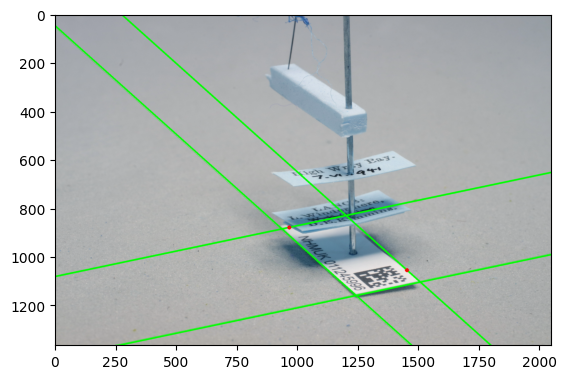

In [911]:
img = deepcopy(view.image)

def extend_line(line, extension_length):

    start_point = line.coords[0]
    end_point = line.coords[1]
    
    # Calculate the direction vector of the line
    direction_vector = np.array(end_point) - np.array(start_point)
    
    # Length of the direction vector
    length = np.linalg.norm(direction_vector)
    
    # Normalize the direction vector
    normalized_direction = direction_vector / length
    
    # Calculate the new start and end points after extension
    extended_start_point = np.array(start_point) - normalized_direction * extension_length
    extended_end_point = np.array(end_point) + normalized_direction * extension_length
    
    return LineString([extended_start_point, extended_end_point])


def calculate_line_slope_intercept(line: LineString):
    # Extract coordinates of the two points
    p1, p2 = line.coords    
    x1, y1 = p1
    x2, y2 = p2    
    # Calculate the differences in y and x coordinates
    delta_y = y2 - y1
    delta_x = x2 - x1    
    # Calculate the slope
    m = delta_y / delta_x    
    # Calculate the intercept
    b = y1 - m * x1
    return m, b

def calculate_perpendicular_distance_point_to_line(x, y, m, b):   
    # Calculate the perpendicular distance from the point to the line
    return abs(m * x - y + b) / np.sqrt(m ** 2 + 1)    

def get_furthest_point_perpendicular_from_line(line: LineString, points):    
    m, b = calculate_line_slope_intercept(line)   
    distances = [calculate_perpendicular_distance_point_to_line(x,y,m,b) for x, y in points]
    return points[np.argmax(distances)]

def get_line_at_point(line: LineString, point, image_width=2000):     
    m, _ = calculate_line_slope_intercept(extended_edge) 
    # Calculate new intercept
    b = point[1] - m * point[0]
    return LineString([(0, b), (image_width, image_width * m + b)])


# # Calculate the coefficients of the line equation
# a = -m_given
# b = 1
# c = -b_given

# max_distance = 0
# furthest_point = None

# for x, y in mask_edge_points:

#     # Calculate the perpendicular distance from the point to the line
#     distance = abs(m_given * x - y + b_given) / np.sqrt(m_given ** 2 + 1)
    
#     if distance > max_distance:
#         max_distance = distance
#         furthest_point = (x, y)


lines = []

for e in ['br_bl', 'bl_tl']:
    edge = LineString(edges[e])
    extended_edge = extend_line(edge, w*h)
    furthest_point = get_furthest_point_perpendicular_from_line(extended_edge, mask_edge_points)
    new_line = get_line_at_point(extended_edge, furthest_point, img.shape[1])

    lines.append((extended_edge, new_line))

    p = np.array(extended_edge.coords).astype(np.int32)
    cv2.line(img, p[0], p[1], (0, 255, 0), 5)
    
    p2 = np.array(new_line.coords).astype(np.int32)
    cv2.line(img, p2[0], p2[1], (0, 255, 0), 5)
    
    # for pt in mask_edge_points:
    #     img = cv2.circle(img, pt, 2, (255,255,0), 1)
    
    img = cv2.circle(img, furthest_point, 5, (255,0,0), 5)
    print("Furthest Point:", furthest_point)
    print("Perpendicular Distance:", max_distance)

# print(lines[0])

box_points = []
for line in lines[0]:
    for perpendicular_line in lines[1]:
        if intersection := line.intersection(perpendicular_line):
            box_points.append(intersection)  



points_np = np.array([(p.x, p.y) for p in box_points], dtype=np.int32)   

x = cv2.convexHull(points_np, clockwise=False)
# cv2.polylines(img, [x], isClosed=True, color=(0, 255, 0), thickness=2)

cv2.fillPoly(img, x, (0, 0, 255))

    
    #     print(perpendicular_line)




plt.imshow(img)
plt.show()

# print(img.shape)

# print(edges)

# -0.8940129449838423
# 1.1185520361990655


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [386]:
from shapely.geometry import Point, LineString

edge = LineString(edges['bl_tl'])



In [634]:
edges

{'tl_tr': ([917.0, 874.0], [1304.0, 911.0]),
 'tr_br': ([1304.0, 911.0], [1498.0, 1105.0]),
 'br_bl': ([1498.0, 1105.0], [1236.0, 1160.0]),
 'bl_tl': ([1236.0, 1160.0], [917.0, 874.0])}

In [639]:
from shapely.geometry import Polygon, box


edge = LineString(edges['bl_tl'])

img = view.image


def extend_line(line, extension_length):

    start_point = line.coords[0]
    end_point = line.coords[1]
    
    # Calculate the direction vector of the line
    direction_vector = np.array(end_point) - np.array(start_point)
    
    # Length of the direction vector
    length = np.linalg.norm(direction_vector)
    
    # Normalize the direction vector
    normalized_direction = direction_vector / length
    
    # Calculate the new start and end points after extension
    extended_start_point = np.array(start_point) - normalized_direction * extension_length
    extended_end_point = np.array(end_point) + normalized_direction * extension_length
    
    return LineString([extended_start_point, extended_end_point])

def get_edge_intersection(image, line):
    h,w = img.shape[:2]
    polygon = box(0, 0, w, h)
    extended_line = extend_line(edge, w+h)
    return polygon.intersection(extended_line)

def cv2_points_to_ints(points):
    # Not necessary - us toint
    return [tuple(map(int, x)) for x in points]



def get_polygon_under_line(image, line):
    # width height of image - need to reverse so order matches line points
    wh = image.shape[:2][::-1]
    line_start, line_end = line.coords    
    line = np.array([line_start, line_end])
    
    points = [
        line_start,
        line_end,
        (line_end[0], h - 1),
        (line_start[0], h - 1)
    ]
    
    for i, dim in enumerate(wh):
        # Maximum coordinate will be the dimension - 1
        max_coord = dim - 1
        for coord in line[:, i]:
            # Is this coord along the edge of the axis
            
            if coord == 0 or coord == max_coord:
                # If it is, add a new point extending the polygon
                pt = [coord]
                pt.insert(i^1, 0)
                points.append(pt)

    
    polygon_points = np.array(points, dtype=np.int32)
    
    # Reorder the points to ensure counter-clockwise winding order
    return cv2.convexHull(polygon_points, clockwise=False)


intersection = get_edge_intersection(img, edge)  

poly = get_polygon_under_line(img, intersection)

coords = cv2_points_to_ints(intersection.coords)    

# print(*l.coords)
# print(*intersection_points.coords)

# print(x)
# print(y)

# print(w)
# print(h)

# x = l.coords
# cv2.line(img, (int(x[0]), int(x[1])), (int(y[0]), int(y[1])), (50, 255, 255), 10)

# img = cv2.circle(img, (1275, 1365), 20, (255,255,0), 30)

# 

# polygon = box(0, 0, w, h)

# print(list(polygon.exterior.coords))

# cv2.fillPoly(img, [list(polygon.exterior.coords)], (0, 0, 255))

# x = ([0, 50], [300, 500])

# p1 = Point(0, 50)
# p2 = Point(300, 500)

# l = LineString([p1, p2])

# cv2.line(img, *x, (50, 255, 255), 10)
# # 

# print(l.coords[1])


# img = deepcopy(view.image)

# # x,y

# img = cv2.circle(img, (1236, 1160), 20, (255,255,0), 30)
# img = cv2.circle(img, (917, 874), 20, (255,255,0), 30)

# cv2.line(img, *coords, (50, 0, 255), 10)
# cv2.fillPoly(img, [poly], (0, 0, 255))
# plt.imshow(img)
# plt.show()

(1365, 2048, 3)
(2048, 1365)
1464.6538461538462
0.0
1365.0
51.86206896551721


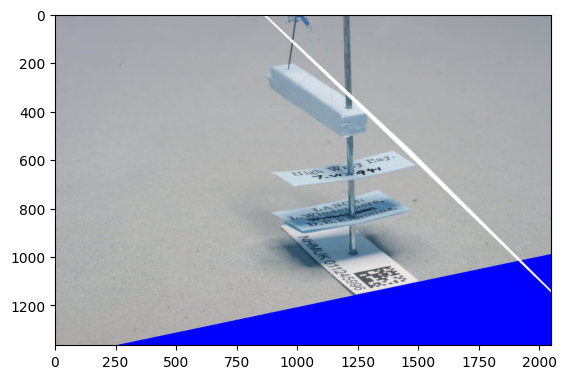

In [732]:
# cv2.fillPoly(img, [poly], (0, 0, 255))
plt.imshow(img)
plt.show()

In [731]:
# Better way of working it!?!?
# https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask


print(calculate_shapely_line_angle(intersection))

h,w = img.shape[:2]
image = np.zeros((h, w), dtype=np.uint8)
mask = view.masks[0]

# Create a binary image with the convex hull
image = cv2.fillPoly(image, [poly], 1)

# from skimage.measure import find_contours
# import math
# # Find contours in the binary mask
contours = find_contours(image, 0.8)

# contour = contours[0].astype(np.float32)

# # Simplify the chosen contour using the Ramer-Douglas-Peucker algorithm
# epsilon = 50  # Adjust epsilon as needed
# simplified_contour = cv2.approxPolyDP(contour, epsilon, closed=True)

# # def numpy_to_tuple_int():

# print(len(simplified_contour))

# for i in range(len(simplified_contour)):
#     print(i)
#     current_point = simplified_contour[i]
#     print(current_point)
#     image = cv2.circle(image, np.squeeze(current_point).astype(int), 20, (255,255,0), 30)
#     # next_point = simplified_contour[(i + 1) % len(simplified_contour)]  # Circular wrapping
#     # print(current_point)
#     # print(next_point)
#     # angle_radians = calculate_line_angle(current_point[0], next_point[0])
#     # print(math.degrees(angle_radians))

print(len(contours))
cv2.drawContours(image, contours, -1, (0,255,0), 20)

# image = cv2.fillPoly(image, [poly], 1)

-2.4106859464330763
1


error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/drawing.cpp:2508: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


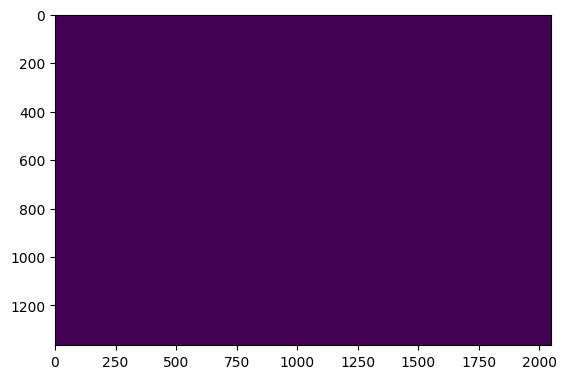

In [728]:
plt.imshow(image)
plt.show()

1000597
yyy


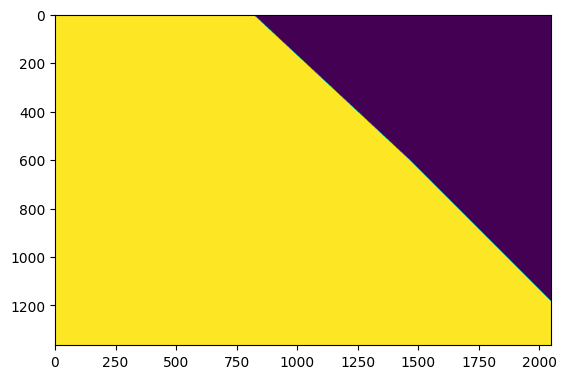

In [693]:
# Create a blank image

h,w = img.shape[:2]
image = np.zeros((h, w), dtype=np.uint8)
mask = view.masks[0]

# Create a binary image with the convex hull
image = cv2.fillPoly(image, [poly], 1)

# while True:
    # np.all(np.logical_and(mask1, mask2))

# # Iteratively dilate the convex hull
iterations = 500  # Number of iterations
kernel = np.ones((3, 3), np.uint8)  # Dilation kernel
print(np.count_nonzero(image))

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

mask_size = np.count_nonzero(mask.numpy())
for _ in range(iterations):
    image = cv2.dilate(image, kernel)
    if np.count_nonzero(image) >= (w * h) - 1:
        break
    # Timeit for these!!! 
    if np.count_nonzero(np.logical_and(mask.numpy(), image)) == mask_size:
        print('yyy')
        break
        # pass

    # print((mask.numpy().astype(int) - image == 1).sum())
        
    # print(np.count_nonzero(mask.numpy() - image))


# print(np.count_nonzero(image))

# image = cv2.fillPoly(image, [mask.numpy()], 1)
# result = cv2.add(image, np.zeros_like(image), mask=mask)

plt.imshow(image)
plt.show()

In [697]:
from skimage.measure import find_contours
import math
# Find contours in the binary mask
contours = find_contours(image, 0.5)

contour = contours[0].astype(np.float32)

# Simplify the chosen contour using the Ramer-Douglas-Peucker algorithm
epsilon = 20  # Adjust epsilon as needed
simplified_contour = cv2.approxPolyDP(contour, epsilon, closed=True)

# dir(edge)

start_point, end_point = edge.coords

def calculate_line_angle(start_point, end_point):
    return math.atan2(end_point[1] - start_point[1], end_point[0] - start_point[0])

def calculate_shapely_line_angle(line):
    start_point, end_point = line.coords
    return calculate_line_angle(*line.coords)

print(calculate_line_angle(start_point, end_point))
print(math.degrees(calculate_line_angle(start_point, end_point)))

print(simplified_contour)

for i in range(len(simplified_contour)):
    current_point = simplified_contour[i]
    next_point = simplified_contour[(i + 1) % len(simplified_contour)]  # Circular wrapping
    print(current_point)
    print(next_point)
    angle_radians = calculate_line_angle(current_point[0], next_point[0])
    print(math.degrees(angle_radians))
    

# print(angle_radians)



# contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# longest_contour = max(contours, key=cv2.arcLength)

# longest_contour = max(contours, key=lambda x: cv2.arcLength(x, True))

# longest_contour

# Convert scikit-image contours to OpenCV polygons
# polygons = [contour[:, [1, 0]] for contour in contours]

# polygons = [np.fliplr(contour).astype(np.int32) for contour in contours]

# # Find the index of the largest contour
# largest_contour_index = np.argmax([len(contour) for contour in contours])

# # Extract the largest contour
# largest_contour = contours[largest_contour_index]

# # Convert the largest contour to an OpenCV polygon format
# polygon = np.fliplr(largest_contour).astype(np.int32)


-2.4106859464330763
-138.12213046211573
[[[   0.   816.5]]

 [[1186.5 2047. ]]]
[[  0.  816.5]]
[[1186.5 2047. ]]
46.042919266106985
[[1186.5 2047. ]]
[[  0.  816.5]]
-133.957080733893


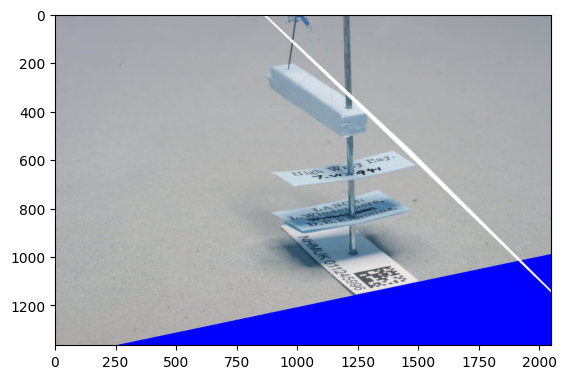

In [653]:
polygons

# # Draw the polygons on the image
cv2.fillPoly(img, [polygon], color=(255, 255, 255))
plt.imshow(img)
plt.show()


In [603]:
np.count_nonzero(mask.numpy())

67194

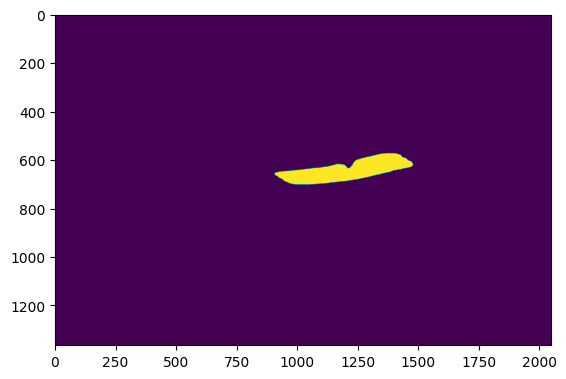

In [606]:
plt.imshow(mask.numpy())
plt.show()

0

In [396]:
# Define the start and end points of the line
start_point = np.array([100, 200])
end_point = np.array([500, 300])


def 

# Calculate the direction vector of the line
direction_vector = end_point - start_point

# Calculate the length of the direction vector
length = np.linalg.norm(direction_vector)

# Normalize the direction vector
normalized_direction = direction_vector / length

# Define the extended length
extended_length = 1000

# Calculate the new start and end points after extension
extended_start_point = start_point - normalized_direction * extended_length
extended_end_point = end_point + normalized_direction * extended_length

print("Extended Start Point:", extended_start_point)
print("Extended End Point:", extended_end_point)

Extended Start Point: [-870.14250015  -42.53562504]
Extended End Point: [1470.14250015  542.53562504]


In [394]:

def extend_line_to_edges(line: LineString, image: np.array):
    w,h = image.shape[:2]
    # Calculate the bounding box of the canvas
    bbox = (0, 0, w, h)

    
    point1 = line.coords[0]
    point2 = line.coords[1]

    # Calculate the slope of the line
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])

    # Calculate the intersection points with the canvas edges
    x_top = bbox[0]
    y_top = int(point1[1] - slope * (point1[0] - x_top))
    
    x_bottom = bbox[0] + bbox[2] - 1
    y_bottom = int(point1[1] + slope * (x_bottom - point1[0]))    

    return (x_top, y_top), (x_bottom, y_bottom)
    
    
l = extend_line_to_edges(edge, img)    

print(l)

# edge = edges['bl_tl']

# # Create a blank canvas
# canvas_width = 800
# canvas_height = 600
# # canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

# # Define the two points of the line
# point1 = edge[0]
# point2 = edge[1]

# # point1 = (100, 300)
# # point2 = (50, 100)

# # Draw the line on the canvas
# # cv2.line(canvas, point1, point2, (0, 255, 0), 5)

# # Calculate the bounding box of the canvas
# bbox = (0, 0, canvas_width, canvas_height)

# # Calculate the slope of the line
# slope = (point2[1] - point1[1]) / (point2[0] - point1[0])

# # Calculate the intersection points with the canvas edges
# x_top = bbox[0]
# y_top = int(point1[1] - slope * (point1[0] - x_top))

# x_bottom = bbox[0] + bbox[2] - 1
# y_bottom = int(point1[1] + slope * (x_bottom - point1[0]))

# y_left = bbox[1]
# x_left = int(point1[0] - (point1[1] - y_left) / slope)

# y_right = bbox[1] + bbox[3] - 1
# x_right = int(point1[0] + (y_right - point1[1]) / slope)

# Draw the extended line on the canvas
# cv2.line(canvas, (x_top, y_top), (x_bottom, y_bottom), (255, 0, 0), 2)  # Top edge
# cv2.line(img, l, (255, 0, 0), 2)  # Left edge

# line_start = (x_left, y_left)
# line_end = (x_right, y_right)

# polygon_points = np.array([
#     line_start,
#     line_end,
#     (line_end[0], canvas_height - 1),
#     (line_start[0], canvas_height - 1)
# ], dtype=np.int32)

# # Draw the polygon on the image
# cv2.fillPoly(canvas, [polygon_points], (0, 0, 255))

# cv2.line(img, *l, (255, 0, 0), 5)
# plt.imshow(img)
# plt.show()


print(image.shape)

((0, 51), (1364, 1274))
(1365, 2048, 3)


In [367]:
# edges = []

# width height of image - need to reverse so order matches line points
wh = canvas.shape[:2][::-1]
line = np.array([line_start, line_end])

points = [
    line_start,
    line_end,
    (line_end[0], canvas_height - 1),
    (line_start[0], canvas_height - 1)
]

for i, dim in enumerate(wh):
    # Maximum coordinate will be the dimension - 1
    max_coord = dim - 1
    for coord in line[:, i]:
        # Is this coord along the edge of the axis
        if coord == 0 or coord == max_coord:
            # If it is, add a new point extending the polygon
            pt = [coord]
            pt.insert(i^1, 0)
            points.append(pt)

polygon_points = np.array(points, dtype=np.int32)

# Reorder the points to ensure counter-clockwise winding order
polygon_points = cv2.convexHull(polygon_points, clockwise=False)


# Check if the polygon is convex
# if not cv2.isContourConvex(polygon_points):
    
# for i 

# np.array([line_start, line_end])



# # line_start
# # line_end

In [360]:
polygon_points

array([[ 25,   0],
       [174, 599],
       [174, 599],
       [ 25, 599],
       [  0,   0],
       [  0, 599]], dtype=int32)

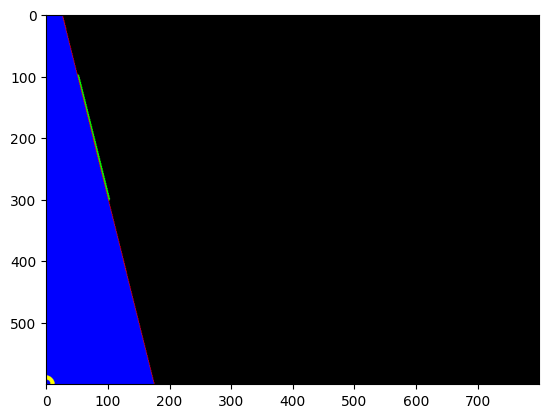

In [368]:
# Draw the polygon on the image
cv2.fillPoly(canvas, [polygon_points], (0, 0, 255))


cv2.circle(canvas, (0, 599), 10, (255,255,0), 5)

plt.imshow(canvas)
plt.show()

In [261]:

# Loop through the keys starting and ending at closest point
x = list(corners.keys())
i = x.index(closest_point)
x[i:] + x[:i] + [closest_point]

# corners[3]

['bl', 'tl', 'tr', 'br', 'bl']

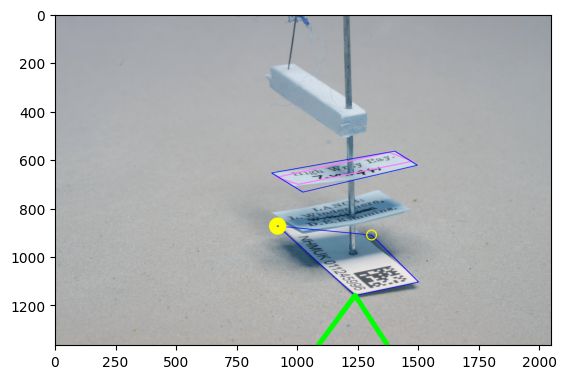

In [227]:
img = cv2.circle(img, (917, 874), 20, (255,255,0), 30)

plt.imshow(img, cmap='gray')
plt.show()

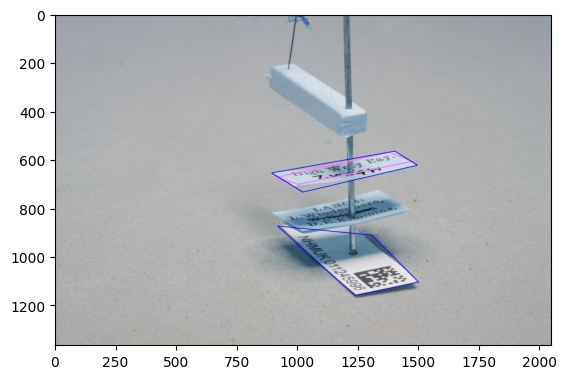

In [146]:
hull = np.int0(hull)
cv2.drawContours(view.image,[hull],0,(0,0,255),2)

# image = np.zeros_like(mask)
# cv2.drawContours(view.image, [box], 0, 1, 2)

# # Display the image using matplotlib
plt.imshow(view.image, cmap='gray')
plt.show()

In [ ]:
# Get nearest corner

# Is it a valid corner (by angle)

# Get the two lines

# Put the two lines as close to the corner, so they do not 


In [138]:
from enum import Enum
from skimage import measure
from copy import deepcopy
import numpy as np
import cv2

view = specimen[1]

# mask = view.masks[0]

mask = view.masks[0].numpy()

x = define_box_around_label(mask, view.image) 

In [139]:
pts = np.array(list(zip(x[0], x[1])), np.int32)

image = cv2.polylines(view.image, [pts], True, (255,120,255),3)

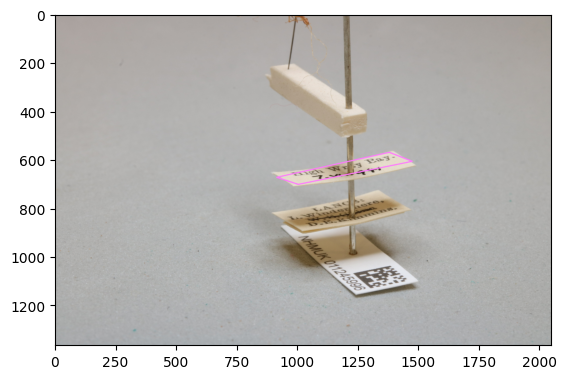

In [140]:
plt.imshow(cv2.cvtColor(view.image, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
import os
import numpy as np
import skimage.io as io
import pandas as pd
from copy import deepcopy
import itertools

def overlap_exclusion(msk_to_exclude_, msk_to_include_, tst):
    msk_to_exclude = tst[msk_to_exclude_]
    msk_to_include = tst[msk_to_include_]
    msk_to_exclude_edit = deepcopy(msk_to_exclude)
    msk_to_exclude_edit[np.where(msk_to_include == True)] = False
    return msk_to_exclude_edit


def review_overlaps(masks, filter_masks=True):

    n_ = np.shape(masks)[0]

    overlaps = []
    for i in range(n_):
        msk1 = masks[i]
        N1 = len(np.where(msk1 == True)[0])
        for j in range(i + 1, n_):
            msk2 = masks[j]
            N2 = len(np.where(msk2 == True)[0])
            N_overlap = len(np.where((msk1 == True) & (msk2 == True))[0])
            R1 = np.round(N_overlap / N1, 4)
            R2 = np.round(N_overlap / N2, 4)
            if (N_overlap != 0) and ((R1 > 0.15) or (R2 > 0.15)):
                overlaps.append([i, j, R1, R2, N_overlap])

    overlaps_sorted = deepcopy(overlaps)
    overlaps_sorted = sorted(overlaps_sorted, key=lambda x: x[4], reverse=True)

    masks_new = deepcopy(masks)

    for o in overlaps_sorted:
        msk1 = masks_new[o[0]]
        msk2 = masks_new[o[1]]
        N_overlap = len(np.where((msk1 == True) & (msk2 == True))[0])
        R1 = np.round(N_overlap / len(np.where(msk1 == True)[0]), 4)
        R2 = np.round(N_overlap / len(np.where(msk2 == True)[0]), 4)

        msk_to_exclude_ = [o[0], o[1]][np.argmax([R1, R2])]
        msk_to_include_ = [o[0], o[1]][np.argmin([R1, R2])]

        new_mask = overlap_exclusion(msk_to_exclude_, msk_to_include_, masks_new)

        masks_new[msk_to_exclude_] = new_mask

    for i in range(n_):
        msk_orig = masks[i]
        msk_new = masks_new[i]
        n1 = len(np.where(msk_orig == True)[0])
        n2 = len(np.where(msk_new == True)[0])
        r = n2 / n1
        if (filter_masks == True) and (r < 0.1):
            masks_new[i] = np.full(np.shape(masks_new[i]), False)

    return masks_new, len(overlaps)


def remove_small_masks(mask, limit=1000):
    masks_filtered = []
    for m in mask:
        p = len(np.where(m == True)[0])
        if p > limit:
            masks_filtered.append(m)
    return masks_filtered


def make_matches(midpoints, temp_midpoints):
    differences = {}
    matches_ind = {}
    for y in np.sort(temp_midpoints):
        v = abs(midpoints - y)
        differences[y] = v
        j = np.argmin(v)
        if j not in matches_ind.values():
            matches_ind[y] = j
        else:
            ky = [k for k in matches_ind.keys() if matches_ind[k] == j][0]
            diffs = differences[ky]
            p1 = diffs[j]
            p2 = v[j]
            if p1 <= p2:
                # original chosen match remains, but we choose the second closest match for current y
                j = np.argsort(v)[1]
                matches_ind[y] = j
            else:
                # change the original match, but keep the current match for the current y
                j_ = np.argsort(v)[1]
                matches_ind[y] = j
                matches_ind[ky] = j_

    return matches_ind


def make_matches_v2(matches_to_be_found, template_to_match):
    iterations = list(
        itertools.permutations(matches_to_be_found, len(template_to_match))
    )
    iterations_indices = list(
        itertools.permutations(enumerate(matches_to_be_found), len(template_to_match))
    )
    diffsum = [sum(abs(np.array(I) - np.sort(template_to_match))) for I in iterations]
    argmin = np.argmin(diffsum)
    matches = iterations[argmin]
    index = iterations_indices[argmin]
    matched_dict = {}
    for u, t in enumerate(np.sort(template_to_match)):
        matched_dict[t] = index[u][0]
    return matched_dict

def remove_small_masks(masks, limit=1000):
    return [m for m in masks if len(np.where(m == True)[0])]    

def match_labels_across_images(masks, max_no_labels=MAX_NUMBER_OF_LABELS):
    # Input: all masks across all 4 images. (np.array)
    # Output: filtered masks across all 4 images. (np.array)

    # 1) Filter masks and remove overlapping regions:
    # all_masks_edited = []  # set of masks after potential overlaps were removed.
    # for masks in all_masks:
    #     masks_new, _ = review_overlaps(masks)  # remove overlaps between masks
    #     masks_new = remove_small_masks(
    #         masks_new, limit=1500
    #     )  # exclude masks that are too small.
    #     all_masks_edited.append(masks_new)

    

    # # 2) Define number of labels to look at:
    # # Note that this number will be less than the maximum number of labels defined with the variable max_no_labels.
    # filtered_msk_count = [
    #     len(m) for m in all_masks_edited
    # ]  # Count of filtered masks per image.
    # min_count = min(
    #     [min(filtered_msk_count), max_no_labels]
    # )  # Select number based on image with the fewest remaining labels.

    # # 3) Select template image/mask:
    # # The masks will be matched across images, based on a template.
    # k = np.argmin(filtered_msk_count)
    # template = all_masks_edited[k]
    # template_mask_sizes = [len(np.where(m == True)[0]) for m in template]
    # template_sorted = np.array(template)[
    #     np.argsort(template_mask_sizes)[::-1][:min_count]
    # ]  # sort template based on mask size.

    # # 4) Find midpoints of masks in template:
    # template_mask_midpoints_y = [
    #     sum([min(np.where(m == True)[0]), max(np.where(m == True)[0])]) / 2
    #     for m in template_sorted
    # ]

    # # 5) Compare midpoints of all masks to template:
    # all_final_masks = []
    # for i in range(4):
    #     mask_midpoints_y = [
    #         sum([min(np.where(m == True)[0]), max(np.where(m == True)[0])]) / 2
    #         for m in all_masks_edited[i]
    #     ]
    #     label_matches_index = make_matches_v2(
    #         mask_midpoints_y, template_mask_midpoints_y
    #     )  # match labels based on the y coordinate of the midpoints.
    #     matched_masks = [all_masks_edited[i][p] for p in label_matches_index.values()]
    #     all_final_masks.append(matched_masks)

    # return all_final_masks
      

match_labels_across_images(masks)

# len(masks)

# def segment_labels_from_image_path(image):
#     # Input: image
#     # Output: masks (np.array)
#     outputs = predict_masks(image)
#     label_masks = outputs["instances"].to("cpu").pred_masks
#     return label_masks, str(image)

# all_original_masks = []

# for image in paths:
#     label_masks = segment_labels_from_image_path(image)
#     all_original_masks.append(label_masks)



# 

3

In [22]:
# all_original_masks

match_masks_across_images(all_original_masks)


/Users/ben/Projects/NaturalHistoryMuseum/ALICE/ALICE/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape


ZeroDivisionError: division by zero

In [12]:
masks = predictions["instances"].to("cpu").pred_masks

TypeError: list indices must be integers or slices, not str

In [9]:
match_masks_across_images(masks)

IndexError: tuple index out of range

In [6]:
# masks = get_segmentation_masks(paths)

In [24]:
x = visualise_mask(paths[1], masks[1])

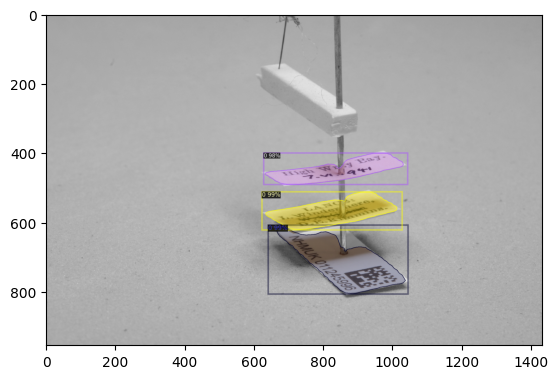

In [25]:
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.show()
